In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich]

In [2]:
from time import time
from discopy.pregroup import brute_force

gen, n_sentences = brute_force(*vocab), 10
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.

8.07 seconds to generate 10 sentences.


Diagram for 'Alice who loves Bob is rich.':


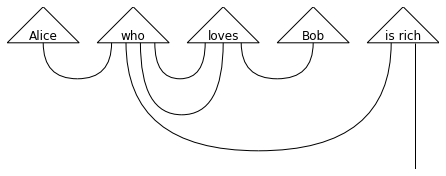

In [3]:
from discopy.pregroup import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice who loves Bob is rich.'], draw_types=False)

Circuit for the GHZ state, used as ansatz for "who":


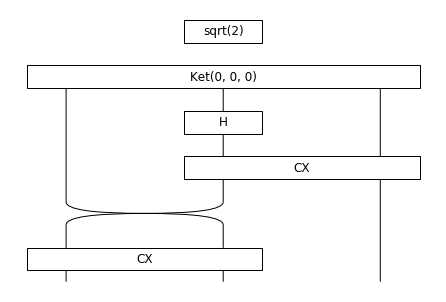

In [4]:
from discopy.circuit import Circuit, sqrt, Ket, H, Rx, CX, SWAP

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state, used as ansatz for \"who\":")
GHZ.draw(aspect='auto', draw_types=False)

Circuit for 'Alice who loves Bob is rich.':


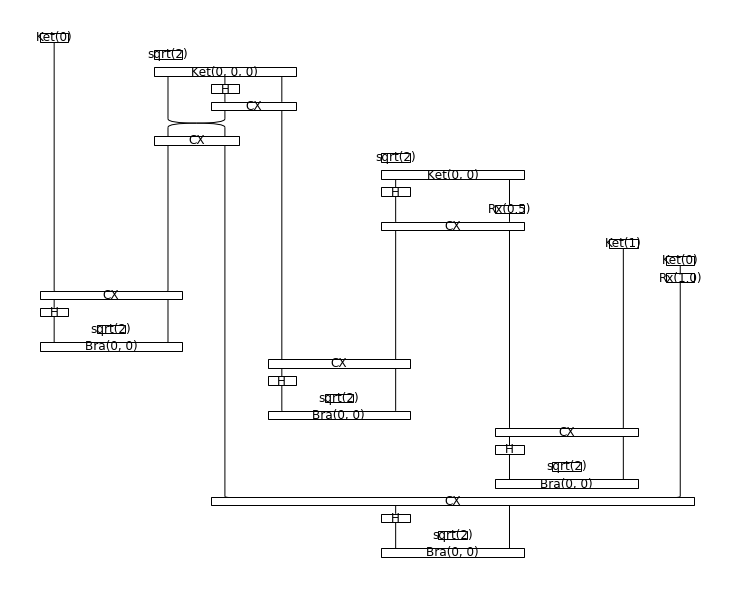

In [5]:
import numpy as np
from discopy import CircuitFunctor

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

F = lambda params: CircuitFunctor(
    ob={s: 0, n: 1},
    ar={Alice: Ket(0),
        loves: transitive_ansatz(params[0]),
        Bob: Ket(1),
        who: GHZ,
        is_rich: intransitive_ansatz(params[1])})

params0 = np.array([0.5, 1.])
print("Circuit for 'Alice who loves Bob is rich.':")
circuit = F(params0)(parsing['Alice who loves Bob is rich.'])
circuit.draw(figsize=(10, 8), aspect='auto', draw_types=False)

In [6]:
from pytket.qiskit import tk_to_qiskit

tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit qubits=8, gates=16>:
Rx(0*PI) q[1];
Rx(1*PI) q[2];
X q[3];
H q[5];
H q[7];
CX q[5], q[2];
CX q[7], q[4];
CX q[7], q[0];
CX q[2], q[3];
CX q[4], q[5];
CX q[0], q[1];
H q[2];
H q[4];
CX q[6], q[7];
H q[0];
H q[6];

post selection:
{6: 0, 7: 0, 4: 0, 5: 0, 2: 0, 3: 0, 0: 0, 1: 0}

scalar:
7.999999046325684

qiskit circuit:


In [7]:
from qiskit import IBMQ
from qiskit.providers.aer import noise

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)

/Users/giovannidefelice/.pyenv/versions/3.7.4/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [8]:
from pytket.backends.ibm import AerBackend, IBMQBackend
from discopy.circuit import tensor_from_counts

# backend = IBMQ singapore
singapore = IBMQBackend('ibmq_singapore', hub='ibmq')

def evaluate(params, sentences, backend=singapore, n_shots=2**10, seed=42):
    circuits = [F(params)(parsing[s]).to_tk().measure_all() for s in sentences]
    list(map(backend.default_compilation_pass.apply, circuits))
    backend.process_circuits(circuits, n_shots=n_shots, seed=seed)
    return [tensor_from_counts(
        backend.get_counts(c, n_shots=n_shots),
        c.post_selection, c.scalar).array for c in circuits]

In [9]:
from time import time

start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .1

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

1.067 seconds to compute the corpus.

True sentences:
Alice is rich. (0.980)
Alice loves Bob. (1.008)
Bob loves Alice. (0.930)
Alice who is rich is rich. (0.922)
Alice who loves Bob is rich. (1.437)

False sentences:
Bob is rich. (0.000)
Alice loves Alice. (0.000)
Bob loves Bob. (0.000)
Bob who is rich is rich. (0.000)
Alice who loves Alice is rich. (0.000)

Maybe sentences:



In [10]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=237)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(str, sentence_test))))

Training set:
Alice who is rich is rich.
Bob is rich.
Alice is rich.
Alice loves Bob.
Alice loves Alice.

Testing set:
Bob loves Bob.
Alice who loves Alice is rich.
Bob loves Alice.
Alice who loves Bob is rich.
Bob who is rich is rich.


In [11]:
import numpy as np

def loss(params, sentences=sentence_train):
    return - np.mean(np.array([
        (corpus[sentence] - scalar) ** 2
        for sentence, scalar in zip(sentences, evaluate(params, sentences))]))

In [12]:
from random import random, seed; seed(337)

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(params, ['Alice who loves Bob is rich.'])[0] > .5 + delta
      else "No, she isn't.")

Random initialisation: [0.2018591  0.83909858]

Is Alice who loves Bob rich?
Job Status: job has successfully run
No, she isn't.


In [13]:
import noisyopt

i, start = 0, time()

def callback(params):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, params))

result = noisyopt.minimizeSPSA(
    loss, params, paired=False, callback=callback, niter=10, a=2)
result

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Epoch 1 (56 seconds since start): [0.20067549 0.84028219]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Epoch 2 (116 seconds since start): [0.38669025 1.02629694]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully

     fun: -0.0062538115
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: array([0.50845427, 0.99380629])

In [14]:
print("Testing loss: {}".format(loss(result.x, sentences=sentence_test)))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Testing loss: -0.08247067034244537


In [15]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(result.x, ['Alice who loves Bob is rich.'])[0] > .5 + delta
      else "No, she isn't.")

Is Alice who loves Bob rich?
Job Status: job has successfully run
Yes, she is.
